In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from soda import profiles


%matplotlib inline
from pygadgetreader import readsnap


%matplotlib inline
def weight_triaxial(r, Ek, Ep, partID, m, bsize, N_Eb, stellar_mass):
    G = 4.30071e-6
    stellar_mass=stellar_mass*1e10
    Ep=Ep-G*m*np.size(r)/np.max(r) #correction term 
    E=Ek+Ep

    shift_energy = -np.min(Ep)
    E += shift_energy
    Ep += shift_energy
    
    #I chose 300 because this code was initially used for cosmological halos which were way too messed up beyond 300 kpc  
    w=np.where((r <300) & (r!=r[0])) 
    r=r[w]
    Ep=Ep[w]
    Ek=Ek[w]
    E=E[w]
    partID=partID[w]
    
    # Histogram of radius to smooth the potential Phi(r)
    #  - spherical averaging for triaxial halos for Laporte 2013
    #
    MIN,MAX = np.min(np.log10(r)), np.max(np.log10(r))
    Nbins= (MAX-MIN)/bsize    
    histo_rad,redges=np.histogram(np.log10(r), bins = np.linspace(MIN, MAX, Nbins))
    rbins=np.ndarray(shape=np.size(redges)-1, dtype=float)    
    for i in range(1,np.size(redges)):
        rbins[i-1]=redges[i-1]-(redges[i]-redges[i-1])/2.
    rbins=10**rbins    
    nn=np.size(rbins)
    binsize_r=np.ndarray(shape=nn, dtype=float)   
    #     binsize_r is evaluated here for g(E) calculation
    for j in range(0,nn): 
        binsize_r[j]=10**redges[j+1]-10**redges[j]

    #TRACER PARAMETRISATION
    bb=0.5 #scale radius
    #nu_tracer=(3.0/(4.0*np.pi*bb**3))*(1.0+(rbins/bb)**2)**(-2.5) # PLUMMER
    nu_tracer=stellar_density(stellar_mass, params)
    
    #Need to do the reverse indices here - 
    pot2=np.ndarray(shape=np.size(histo_rad), dtype=float)
    for j in range(0, np.size(redges)-1):
        wbin=np.where((np.log10(r)>=redges[j]) & (np.log10(r)<redges[j+1]))
        if(np.size(wbin)>0):
            pot2[j]=np.mean(Ep[wbin]) #reverse indices in IDL is much faster than this junk
    
    # forgot why I wanted more than 20 particles in the bins, maybe sth to do with gradient not working with missing data
    w=np.where(histo_rad>20.)
    rbins=rbins[w]
    binsize_r=binsize_r[w]
    nu_tracer=nu_tracer[w]
    pot2=pot2[w]
    pot2-=shift_energy
    psi2=(-1.0)*pot2
    E-=shift_energy
    epsilon=(-1.0)*E   

    #Fetching derivatives from the data necessary for the Eddington formula evalution
    dnu_dpsi=np.gradient(nu_tracer, psi2)
    dnu2_dpsi2=np.gradient(dnu_dpsi, psi2)
    
    #Binning Energy for g(E) and f(E) (f(epsilon)) calculations                                
    Histo_E, Edges = np.histogram(E, bins=N_Eb)
    Ebins=np.ndarray(shape=np.size(Histo_E), dtype=float)
    for i in range(1,np.size(Edges)):
        Ebins[i-1]=Edges[i-1]-(Edges[i]-Edges[i-1])/2.
        
    Histo_epsilon, epsdges = np.histogram(epsilon, bins=N_Eb)
    epsilon_bins=np.ndarray(shape=np.size(Histo_epsilon), dtype=float)
    for i in range(1,np.size(epsdges)):
        epsilon_bins[i-1]=epsdges[i-1]-(epsdges[i]-epsdges[i-1])/2.

        
    #Total N(E) differential energy distribution
    Histo_M=Histo_E*m/np.sqrt((Ebins[2]-Ebins[1])**2) 

    # EDDINGTON FORMULA --------------
    dpsi=np.ndarray(shape=np.size(psi2), dtype=float)
    for i in range (1, np.size(dpsi)):
        dpsi[i]=psi2[i]-psi2[i-1]
    distribution_function=np.ndarray(shape=np.size(epsilon_bins), dtype=float)
    for i in range(0,np.size(epsilon_bins)):
        w=np.where(psi2<epsilon_bins[i])
        #x=np.min(w) #i don't think I use this anywhere
        eps=epsilon_bins[i]
        if (np.size(w[0])!=0):
            w=np.array(w)
            tot1=dpsi[w[0,0]::]
            tot2=dnu2_dpsi2[w[0,0]::]
            tot3=np.sqrt(2.0*(eps-psi2[w[0,0]::]))
            tot=tot1*tot2/tot3
            val=(1.0)/(np.sqrt(8.0)*np.pi**2)*np.sum(tot) #Arthur's eval as Sum (in sims no divergence due to res)
            #print val, i, "val, i"
            distribution_function[i]=val
        else:
            distribution_function[i]=0
            
    #DENSITY OF STATES--------------
    wrme=np.ndarray(shape=np.size(Ebins), dtype=int)
    rme=np.ndarray(shape=np.size(Ebins), dtype=float)
    for i in range(0, np.size(Ebins)): 
        wpot_equals_E=np.where(pot2<=Ebins[i]) 
        if (np.size(wpot_equals_E)!=0):
            wrme[i]=np.max(np.array(wpot_equals_E))
        else:
            wrme[i]=0
            
    density_of_states=np.ndarray(shape=np.size(Ebins), dtype=float) # density of states integral (evaluated as sum)
    for i in range(0,np.size(Ebins)):
        if (np.size(wrme[i])==0):
            g1=0.0 
        else:
            g1=rbins[0:wrme[i]]**2
            g2=np.sqrt(2.0*(Ebins[i]-pot2[0:wrme[i]]))
            density_of_states[i]=(4.0*np.pi)**2*np.sum(binsize_r[0:wrme[i]]*g1*g2)
                                                              
    indsort=np.argsort(distribution_function) #sorted indices
    indsort=indsort[::-1] #reverse   
    # weights= D.F(tracers)/ (D.F.(self-consistent)) - self-consistent D.F. f(E) generates the potential Phi 
    # N(E)=f(E)*g(E)
    Weights=distribution_function[indsort[::-1]]/((Histo_M)/density_of_states) 

    # cast the weights to every particle
    Weights_array=np.ndarray(shape=np.size(r), dtype=float) 
    for j in range(0, np.size(Edges)-1):
        wbin=np.where((E>=Edges[j]) & (E<Edges[j+1]))
        if(np.size(wbin[0])!=0):
            Weights_array[wbin]=Weights[j] 
    
    #Ensure that the sum of the weights = mass of the tracers - this is not strictly needed
    X=stellar_mass/(np.sum(Weights_array)*m)
    Weights_array=Weights_array*X
    print(X)
    #print(np.size(Weights_array))
    #return the IDS from which the weights are associated to the particles
    #needed for tracking where the tracers end up in subsequent snapshots
    return {'weights':Weights_array, 'ids':partID} 



# TESTING STUFF - used a Hernquist profile with scale radius a=0.5kpc and M=1*1e10 as input - was able to confirm
# the density profile through the calculation of weights for a tracer following the self-consistent solution.

def potential_hernquist(r,M,a):
    G = 4.30071e-6
    pot=-G*M/(r+a)
    return pot

"""
filename='./halos/spherical_010'
f = open(filename,'rb')    
blocksize = np.fromfile(f,dtype=np.int32,count=1)[0]
print(blocksize)
bytesleft=96
npart=np.fromfile(f, dtype=np.int32, count=6)
massarr = np.fromfile(f,dtype=np.float64,count=6)
time = (np.fromfile(f,dtype=np.float64,count=1))[0]
redshift = (np.fromfile(f,dtype=np.float64,count=1))[0]
sfr=(np.fromfile(f,dtype=np.int32,count=1))[0]
feedback = (np.fromfile(f,dtype=np.int32,count=1))[0]
nall = np.fromfile(f,dtype=np.int32,count=6)
cooling = (np.fromfile(f,dtype=np.int32,count=1))[0]
filenum = (np.fromfile(f,dtype=np.int32,count=1))[0]
boxsize = (np.fromfile(f,dtype=np.float64,count=1))[0]
omega_m = (np.fromfile(f,dtype=np.float64,count=1))[0]
omega_l = (np.fromfile(f,dtype=np.float64,count=1))[0]
hubble = (np.fromfile(f,dtype=np.float64,count=1))[0]
headerend = np.fromfile(f, dtype=np.int8, count=96)
blocksize = np.fromfile(f,dtype=np.int32,count=1)[0]
#print headerend
#print blocksize
#blocksize = np.fromfile(f,dtype=np.int32,count=1)[0]
#print blocksize, 'blocksize pp'
#ntot=np.int64(np.sum(npart))
dt = np.dtype((np.float32,3)) # type of entry for POS, VEL, ACCEL, etc.
pp=np.fromfile(f, dtype=np.dtype(dt), count=np.sum(npart))
#print pp, np.size(pp)
blocksize = np.fromfile(f,dtype=np.uint32,count=1)[0]
#print blocksize, 'blocksize pp'


#blocksize = np.fromfile(f,dtype=np.uint32,count=1)[0]
#print blocksize, 'blocksize vv'
vv=np.fromfile(f, dtype=dt, count=np.sum(npart))
blocksize = np.fromfile(f,dtype=np.uint32,count=1)[0]
#print blocksize, 'blocksize vv'


blocksize = np.fromfile(f,dtype=np.uint32,count=1)[0]
#print blocksize, 'blocksize ids'
ids=np.fromfile(f, dtype=np.uint32, count=np.sum(npart))
#print ids, 'ids'
blocksize = np.fromfile(f,dtype=np.uint32,count=1)[0]
#print blocksize, 'blocksize ids'
"""




/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


"\nfilename='./halos/spherical_010'\nf = open(filename,'rb')    \nblocksize = np.fromfile(f,dtype=np.int32,count=1)[0]\nprint(blocksize)\nbytesleft=96\nnpart=np.fromfile(f, dtype=np.int32, count=6)\nmassarr = np.fromfile(f,dtype=np.float64,count=6)\ntime = (np.fromfile(f,dtype=np.float64,count=1))[0]\nredshift = (np.fromfile(f,dtype=np.float64,count=1))[0]\nsfr=(np.fromfile(f,dtype=np.int32,count=1))[0]\nfeedback = (np.fromfile(f,dtype=np.int32,count=1))[0]\nnall = np.fromfile(f,dtype=np.int32,count=6)\ncooling = (np.fromfile(f,dtype=np.int32,count=1))[0]\nfilenum = (np.fromfile(f,dtype=np.int32,count=1))[0]\nboxsize = (np.fromfile(f,dtype=np.float64,count=1))[0]\nomega_m = (np.fromfile(f,dtype=np.float64,count=1))[0]\nomega_l = (np.fromfile(f,dtype=np.float64,count=1))[0]\nhubble = (np.fromfile(f,dtype=np.float64,count=1))[0]\nheaderend = np.fromfile(f, dtype=np.int8, count=96)\nblocksize = np.fromfile(f,dtype=np.int32,count=1)[0]\n#print headerend\n#print blocksize\n#blocksize = np.f

In [2]:
pp= readsnap('./halos/LMC6_6.25M_vir_000', 'pos', 'dm')
vv= readsnap('./halos/LMC6_6.25M_vir_000', 'vel', 'dm')

massarr= readsnap('./halos/LMC6_6.25M_vir_000', 'mass', 'dm')
Epp = readsnap('./halos/LMC6_6.25M_vir_000', 'pot', 'dm')
ids = readsnap('./halos/LMC6_6.25M_vir_000', 'pid', 'dm')
rr=np.sqrt(pp[:,0]**2+pp[:,1]**2+pp[:,2]**2)


r_cut = index = np.where(rr<100)[0]

pp = pp[r_cut]
rr = rr[r_cut]
vv = vv[r_cut]

massarr = massarr[r_cut]
Epp = Epp[r_cut]
ids = ids[r_cut]

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [3]:
#rr=np.sqrt(pp[:,0]**2+pp[:,1]**2+pp[:,2]**2)
partmass=massarr[3]*1e10 #generated the halo particles as "bulge"-type in Gadget file
a=0.5
v2=vv[:,0]**2+vv[:,1]**2+vv[:,2]**2
Ekk=0.5*v2

result=weight_triaxial(rr,Ekk,Epp,ids,partmass,0.01,100,1)
ids=result['ids']
weights=result['weights']


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


NameError: name 'stellar_density' is not defined

In [207]:
np.sum(weights)

250022.42737169765

In [208]:
1E10/partmass

250022.42737169744

0
62511214188.7
39996.4119424


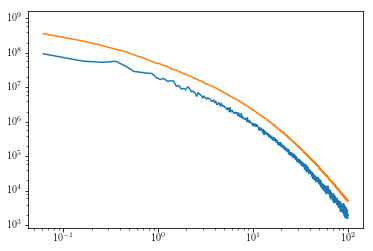

In [209]:
s=np.argsort(ids)
weights=weights[s]
w=np.where(ids>1)
rr=rr[w]

h,redges=np.histogram(rr, bins=1000)
rbins=np.ndarray(shape=np.size(redges)-1, dtype=float)    
for i in range(1,np.size(redges)):
    rbins[i-1]=redges[i-1]-(redges[i]-redges[i-1])/2.

c=0
mass=np.ndarray(shape=np.size(h), dtype=float)    
for i in range(0,np.size(h)):
    wbin=np.where((rr>=redges[i]) & (rr<redges[i+1]))
    if(np.size(wbin)>0):
        mass[i]=np.sum(weights[wbin])*1E10/partmass #reverse indices in IDL is much faster than this junk
    else:
        c+1
        mass[i]=0.0
print(c)
        
masst=np.ndarray(shape=np.size(h), dtype=float)    
masst=h*partmass

print(sum(weights)*1E10/partmass)
print(partmass)
        
        
#print np.sum(mass)

shell=np.ndarray(shape=np.size(h), dtype=float)
for i in range(0, np.size(redges)-1):
    shell[i]=4./3.*np.pi*(redges[i+1]**3-redges[i]**3)

density=mass/shell

densityt=masst/shell



plt.loglog((rbins),(density))

plt.loglog((rbins),(densityt))

# seems rather noisy at large radii for the reconstructed tracer density profile
#
# can be solved with proper interpolation scheme when deriving values for dnu-dpsi d2nu_dpsi2 or maybe some better type of binning...



In [ ]:
def stellar_density(stellar_mass, params):
    if params[]
    (stellar_mass*bb/(2.0*np.pi*rbins))/(bb+rbins)**3 # HERNQUIST
